In [12]:
import torch
import numpy as np
import pandas as pd

In [7]:
from sklearn.model_selection import train_test_split

In [4]:
df = pd.read_csv("../datasets/xor.csv")

In [5]:
df.head()

,x1,x2,class label
0,0.781306,1.062984,0
1,-1.060524,-1.095550,0
2,0.632125,0.674028,0
3,-1.424712,0.535203,1
4,1.383161,1.368510,0


In [6]:
X = df[["x1", "x2"]].values
y = df["class label"].values

In [9]:
X_train, X_test, y_train, y_test = train_test_split(
  X,
  y,
  stratify = y,
  shuffle = True,
  test_size = 0.15,
  random_state = 1
)

In [10]:
X_train, X_val, y_train, y_val = train_test_split(
  X_train,
  y_train,
  shuffle = True,
  test_size = 0.1,
  random_state = 1,
  stratify = y_train
)

In [11]:
print(f'Training size: {X_train.shape}')
print(f'Validation size: {X_val.shape}')
print(f'Testing size: {X_test.shape}')

Training size: (573, 2)
Validation size: (64, 2)
Testing size: (113, 2)


In [13]:
print(f'Training labels: {np.bincount(y_train)}')
print(f'Validation labels: {np.bincount(y_val)}')
print(f'Test labels: {np.bincount(y_test)}')

Training labels: [287 286]
Validation labels: [32 32]
Test labels: [57 56]


### **Visualize the dataset**

In [14]:
import matplotlib.pyplot as plt

import matplotlib as mpl
mpl.rcParams['savefig.dpi'] = 80
mpl.rcParams['figure.dpi'] = 300

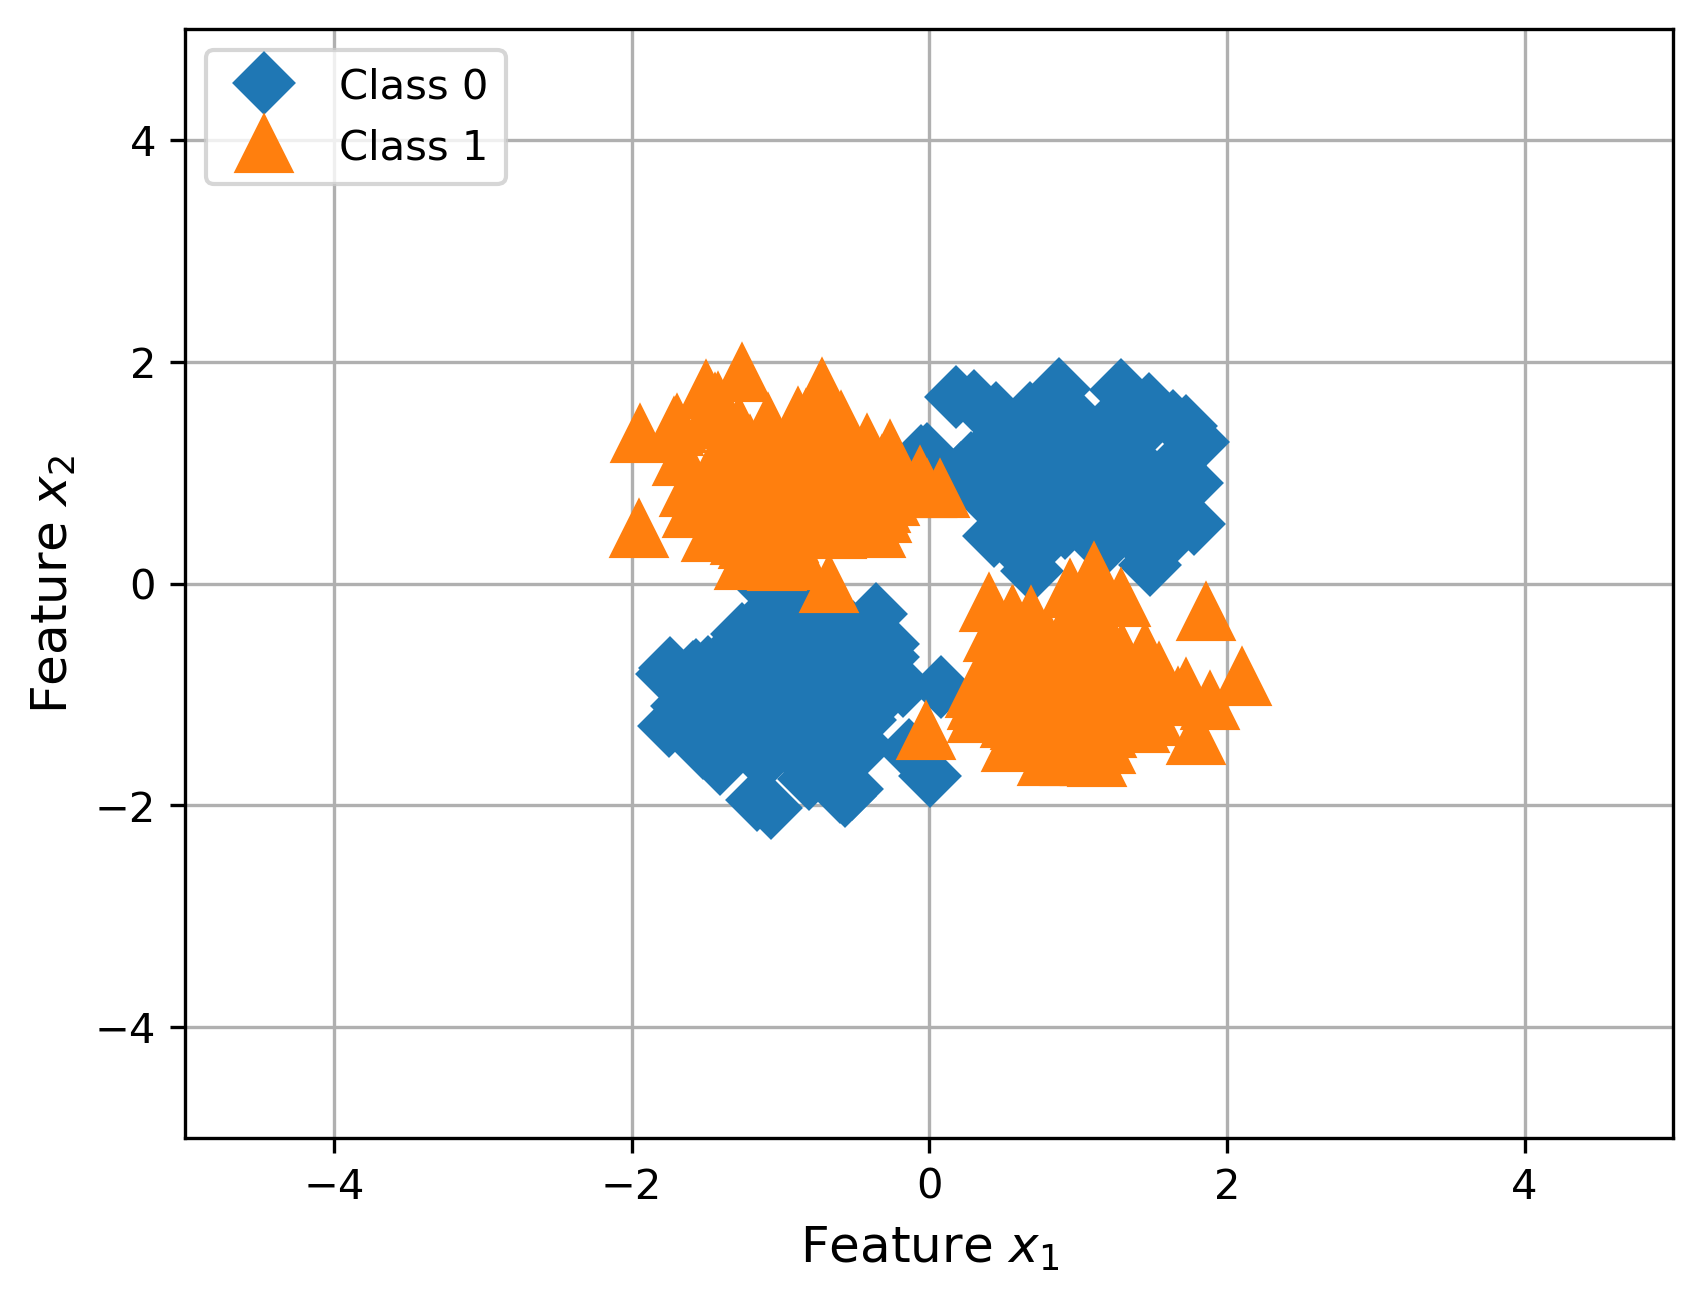

In [15]:
plt.plot(
  X_train[y_train == 0, 0],
  X_train[y_train == 0, 1],
  marker="D",
  markersize=10,
  linestyle="",
  label="Class 0",
)

plt.plot(
  X_train[y_train == 1, 0],
  X_train[y_train == 1, 1],
  marker="^",
  markersize=13,
  linestyle="",
  label="Class 1",
)

plt.legend(loc=2)

plt.xlim([-5, 5])
plt.ylim([-5, 5])

plt.xlabel("Feature $x_1$", fontsize=12)
plt.ylabel("Feature $x_2$", fontsize=12)

plt.grid()
plt.show()

### **Implementing the model**

In [16]:
class MLP(torch.nn.Module):
  def __init__(self, num_features, num_classes):
    super().__init__()
    self.layers = torch.nn.Sequential(
      # 1st hidden layer
      torch.nn.Linear(num_features, 25),
      torch.nn.ReLU(),

      # 2nd hidden layer
      torch.nn.Linear(25, 15),
      torch.nn.ReLU(),

      # Output layer
      torch.nn.Linear(15, num_classes)
    )
  
  def forward(self, x):
    logits = self.layers(x)
    return logits

### **Define the DataLoader**

In [17]:
from torch.utils.data import Dataset, DataLoader

In [18]:
class MyDataset(Dataset):
  def __init__(self, X, y):
    self.features = torch.tensor(X, dtype = torch.float32)
    self.labels = torch.tensor(y, dtype = torch.int64)

  def __getitem__(self, index):
    x = self.features[index]
    y = self.labels[index]        

    return x, y

  def __len__(self):
    return self.labels.shape[0]

In [19]:
train_ds = MyDataset(X_train, y_train)
val_ds = MyDataset(X_val, y_val)
test_ds = MyDataset(X_test, y_test)

In [26]:
train_loader = DataLoader(
  dataset = train_ds,
  batch_size = 32,
  shuffle = True,
)

val_loader = DataLoader(
  dataset = val_ds,
  batch_size = 32,
  shuffle = False,
)

test_loader = DataLoader(
  dataset = test_ds,
  batch_size = 32,
  shuffle = False,
)

### **Training loop**

In [23]:
import torch.nn.functional as F

In [24]:
torch.manual_seed(1)

In [22]:
def accuracy(model, dataloader):
  model = model.eval()
  correct = 0.0
  total = 0

  for idx, (features, labels) in enumerate(dataloader):
    with torch.inference_mode():  # Same as `torch.no_grad()`
      logits = model(features)
    
    predictions = torch.argmax(logits, dim = 1)
    compare = labels == predictions
    correct += torch.sum(compare)
    total += len(compare)
  
  return correct / total

In [25]:
epochs = 10
model = MLP(num_features = 2, num_classes = 2)
optimizer = torch.optim.SGD(model.parameters(), lr = 0.05)

In [27]:
for epoch in range(epochs):
  model = model.train()

  for batch_idx, (features, labels) in enumerate(train_loader):
    logits = model(features)
    loss = F.cross_entropy(logits, labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    print(f'Epoch: {epoch + 1:03d}/{epochs:03d}'
          f' | Batch {batch_idx:03d}/{len(train_loader):03d}'
          f' | Train/Val loss: {loss:.2f}')
  
  train_acc = accuracy(model, train_loader)
  val_acc = accuracy(model, val_loader)
  print(f'Train accuracy: {train_acc * 100:.2f}% | Val accuracy: {val_acc * 100:.2f}%')

Epoch: 001/010 | Batch 000/018 | Train/Val loss: 0.68
Epoch: 001/010 | Batch 001/018 | Train/Val loss: 0.69
Epoch: 001/010 | Batch 002/018 | Train/Val loss: 0.68
Epoch: 001/010 | Batch 003/018 | Train/Val loss: 0.67
Epoch: 001/010 | Batch 004/018 | Train/Val loss: 0.69
Epoch: 001/010 | Batch 005/018 | Train/Val loss: 0.68
Epoch: 001/010 | Batch 006/018 | Train/Val loss: 0.66
Epoch: 001/010 | Batch 007/018 | Train/Val loss: 0.68
Epoch: 001/010 | Batch 008/018 | Train/Val loss: 0.67
Epoch: 001/010 | Batch 009/018 | Train/Val loss: 0.68
Epoch: 001/010 | Batch 010/018 | Train/Val loss: 0.66
Epoch: 001/010 | Batch 011/018 | Train/Val loss: 0.65
Epoch: 001/010 | Batch 012/018 | Train/Val loss: 0.67
Epoch: 001/010 | Batch 013/018 | Train/Val loss: 0.67
Epoch: 001/010 | Batch 014/018 | Train/Val loss: 0.65
Epoch: 001/010 | Batch 015/018 | Train/Val loss: 0.67
Epoch: 001/010 | Batch 016/018 | Train/Val loss: 0.67
Epoch: 001/010 | Batch 017/018 | Train/Val loss: 0.65
Train accuracy: 68.41% | Val

### **Evalute our model**

In [28]:
train_acc = accuracy(model, train_loader)
val_acc = accuracy(model, val_loader)
test_acc = accuracy(model, test_loader)

print(f'Train accuracy: {train_acc * 100:.2f}%')
print(f'Validation accuracy: {val_acc * 100:.2f}%')
print(f'Test accuracy: {test_acc * 100:.2f}%')

Train accuracy: 98.25%
Validation accuracy: 100.00%
Test accuracy: 99.12%


### **Visualize the decision boundary**

In [29]:
from matplotlib.colors import ListedColormap

In [30]:
def plot_decision_regions(X, y, classifier, resolution=0.02):
  # setup marker generator and color map
  markers = ('D', '^', 'x', 's', 'v')
  colors = ('C0', 'C1', 'C2', 'C3', 'C4')
  cmap = ListedColormap(colors[:len(np.unique(y))])

  # plot the decision surface
  x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
  x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
  xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                          np.arange(x2_min, x2_max, resolution))
  tensor = torch.tensor(np.array([xx1.ravel(), xx2.ravel()]).T).float()
  logits = classifier.forward(tensor)
  Z = np.argmax(logits.detach().numpy(), axis=1)

  Z = Z.reshape(xx1.shape)
  plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
  plt.xlim(xx1.min(), xx1.max())
  plt.ylim(xx2.min(), xx2.max())

  # plot class samples
  for idx, cl in enumerate(np.unique(y)):
    plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1],
                alpha=0.8, color=cmap(idx),
                #edgecolor='black',
                marker=markers[idx], 
                label=cl)

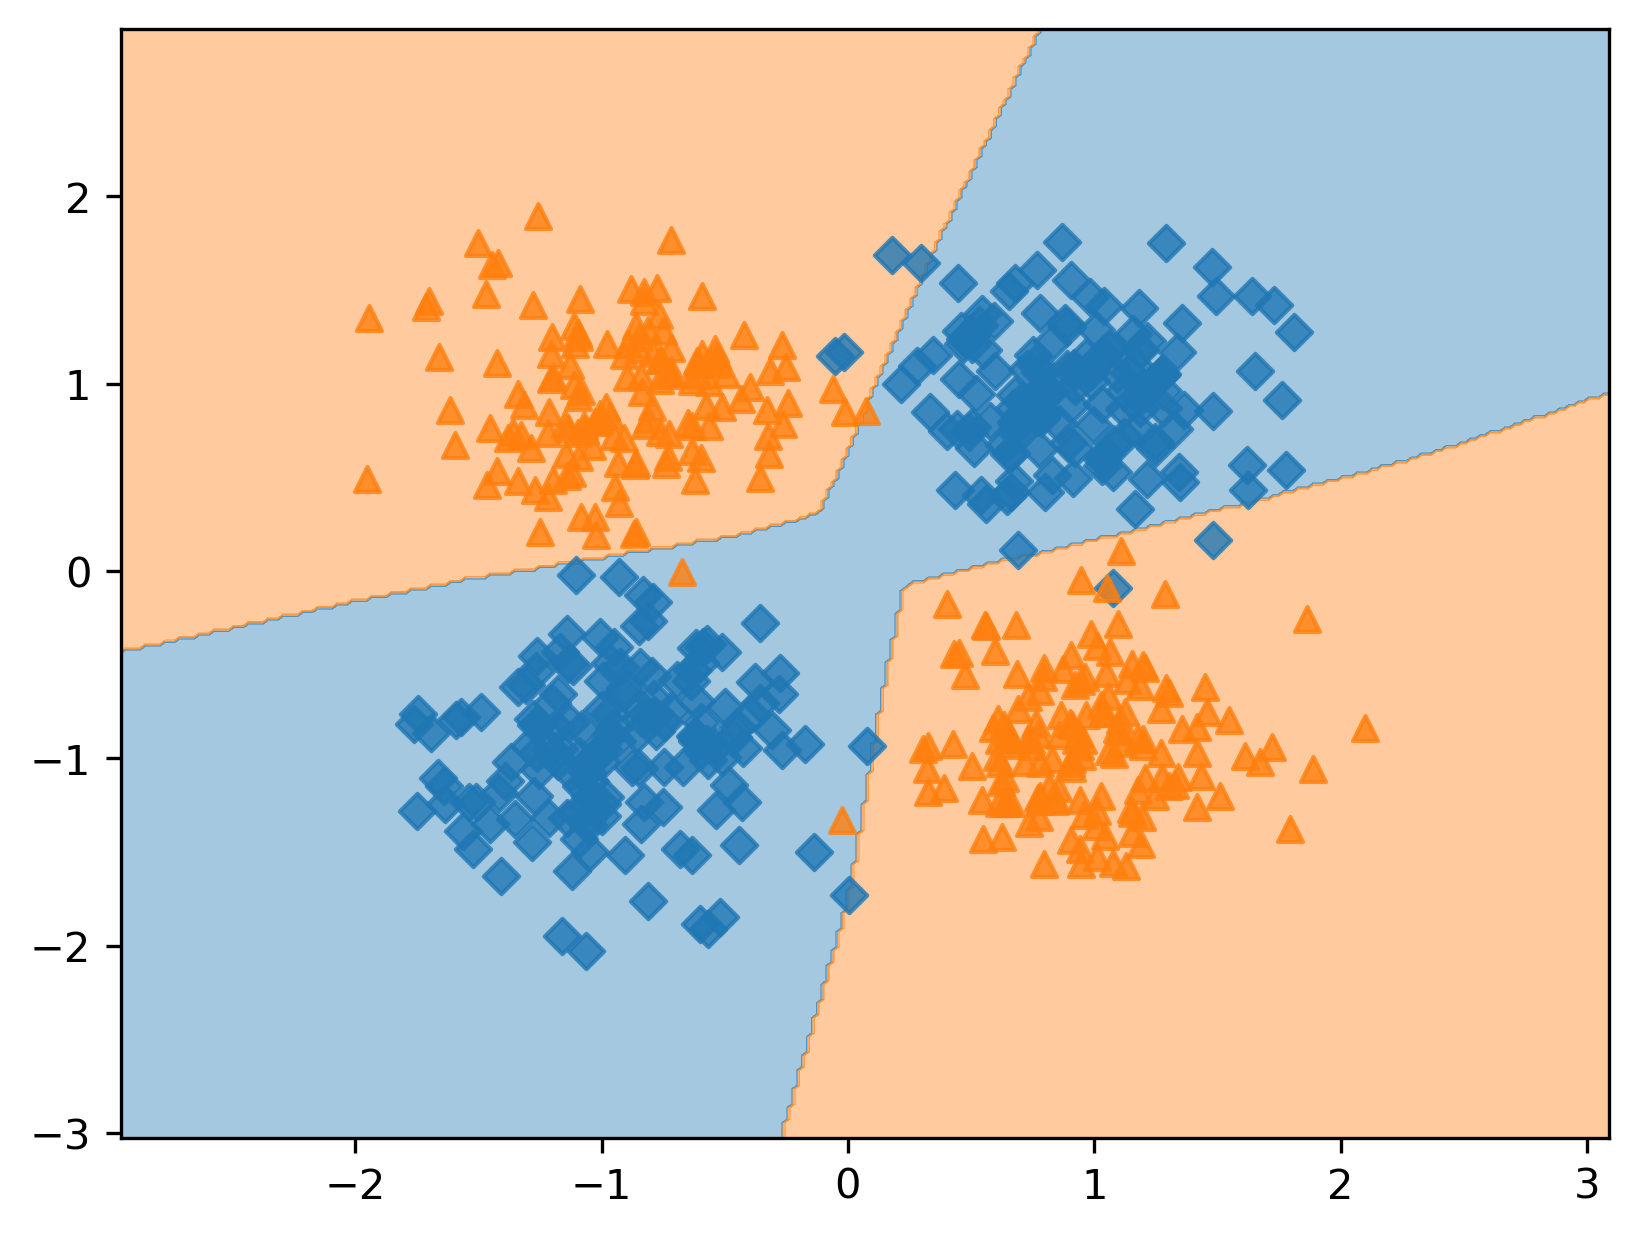

In [31]:
plot_decision_regions(X_train, y_train, classifier = model)